In [1]:
import pandas as pd
import numpy as np
import os
from os import path
from matplotlib import pyplot as plt
import datetime
from scipy.special import softmax
%matplotlib inline

In [2]:
cd drive/MyDrive/accenture_hackaton/

/content/drive/MyDrive/accenture_hackaton


In [3]:
data_dir = "data/"

#Загружаем данные

In [4]:
promo_history = pd.read_excel(path.join(data_dir, 'promo_history.xlsx'))
sales_history = pd.read_csv(path.join(data_dir, 'sales_history.csv'))

In [5]:
promo_history.drop(columns=['Unnamed: 0', 0], inplace=True)
sales_history.drop(columns=['Unnamed: 0'], inplace=True)

In [195]:
promo_history.head()

,start_dttm,end_dttm,skutertiaryid,promotypeid,chaindiscountvalue,profit
0,2019-01-16,2019-01-29,7205,67,0.228495,2.141270e+05
1,2019-01-16,2019-01-29,7234,67,0.239229,1.167186e+06
2,2019-02-13,2019-02-26,7182,70,0.233531,4.649060e+05
3,2019-02-13,2019-02-26,7205,67,0.221040,2.372418e+05
4,2019-02-13,2019-02-26,7234,67,0.216858,1.157057e+06


In [7]:
sales_history.head()

,salerevenuerub,soldpieces,skutertiaryid,posid,sale_dt
0,174.41639,2,7182,293136,2018-04-30
1,261.64140,3,7182,293136,2018-04-23
2,78.75025,1,7182,296672,2018-04-30
3,630.03563,8,7182,296672,2018-04-23
4,239.12051,3,7182,296833,2018-04-30


In [8]:
sales_history['sale_dt'] = sales_history['sale_dt'].apply(lambda x: datetime.datetime.fromisoformat(x))

###Посчитаем количество уникальных товаров

In [31]:
products = np.unique(sales_history['skutertiaryid'].values)
f'Количество уникальных товаров: {len(products)}'

'Количество уникальных товаров: 10'

###Посчитаем прибыль для каждой проведенной акции

In [39]:
profits = []
for i in range(len(promo_history)):
  data = promo_history.iloc[i]
  start = data['start_dttm']
  end = data['end_dttm']
  product = data['skutertiaryid']

  history = sales_history[(sales_history['sale_dt'] >= start) & (sales_history['sale_dt'] <= end) & (sales_history['skutertiaryid']==product)]
  earn = history['salerevenuerub'].sum()
  expenses = (history['salerevenuerub'] * data['chaindiscountvalue']).sum()
  profit = (earn - expenses)/(end-start).days
  profits.append(profit)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [40]:
profit_frame = pd.Series(profits)
promo_history['profit'] = profit_frame

In [231]:
promo_history[promo_history['skutertiaryid'] == products[7]].head()

,start_dttm,end_dttm,skutertiaryid,promotypeid,chaindiscountvalue,profit
12,2019-05-07,2019-05-07,7236,70,0.185099,NaN
26,2019-07-24,2019-07-30,7236,70,0.213979,27766.436442
32,2019-09-11,2019-09-17,7236,70,0.186274,72087.346164
58,2021-01-27,2021-02-02,7236,70,0.200000,0.000000
67,2021-02-24,2021-03-02,7236,70,0.200000,0.000000


###Проанализируем зависимость прибыли от размера скидки для каждого продукта

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


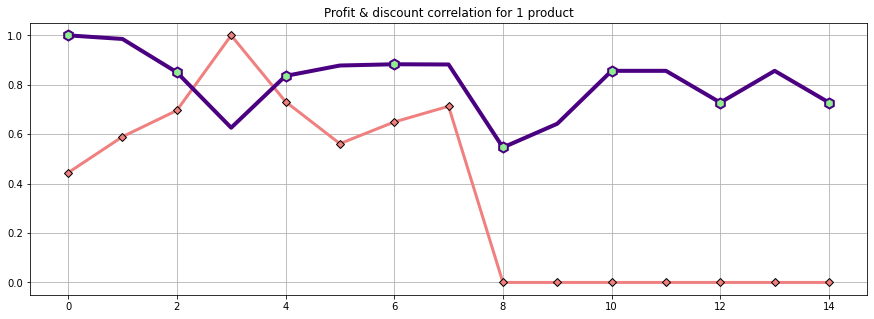

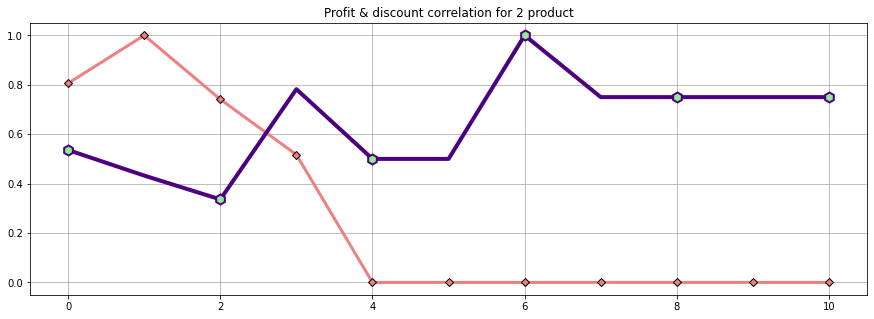

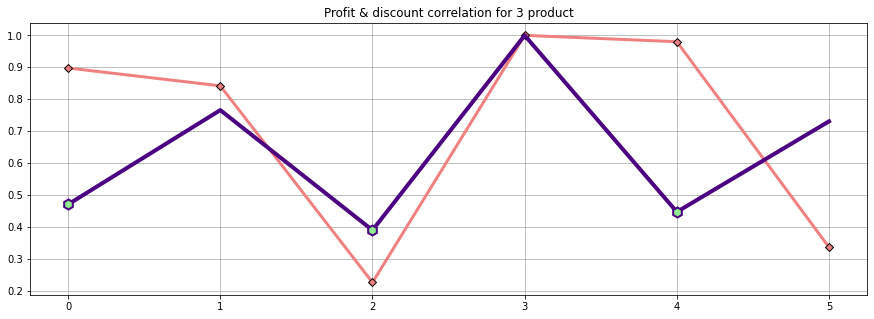

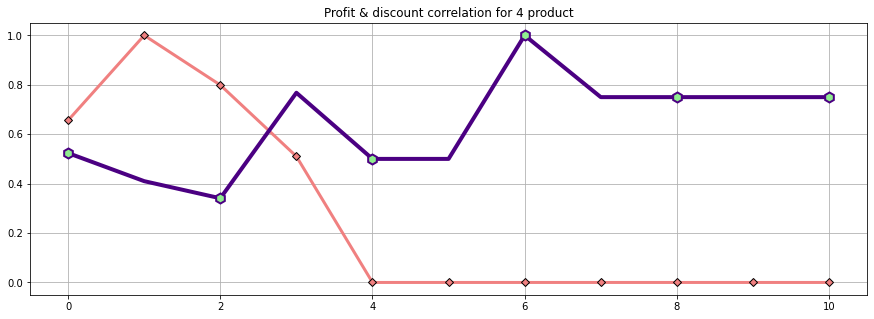

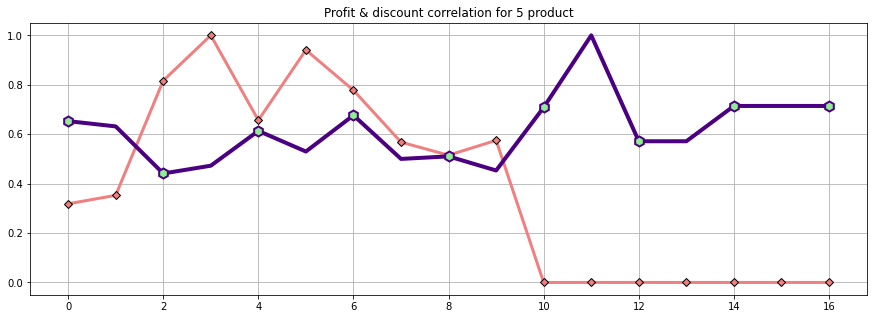

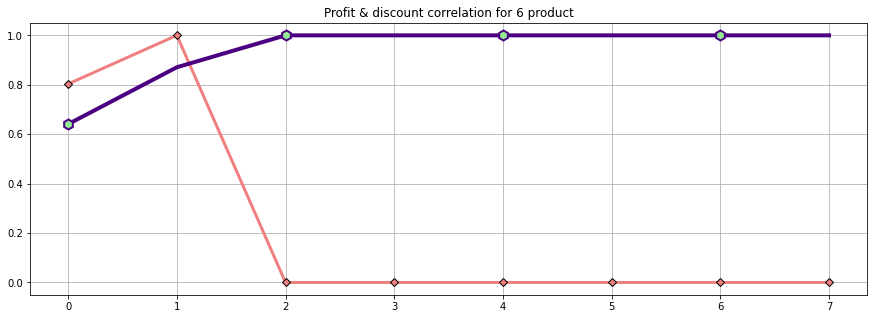

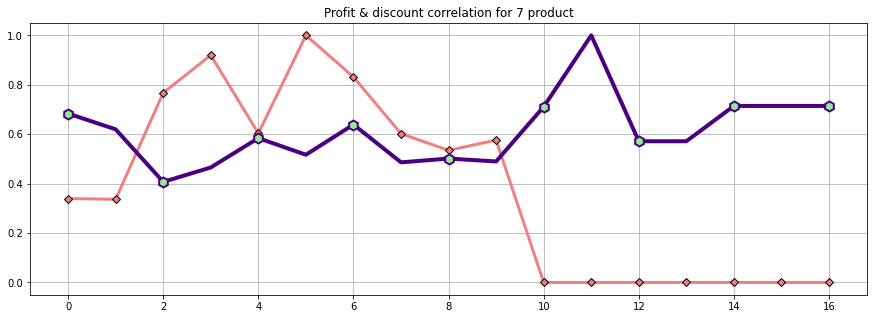

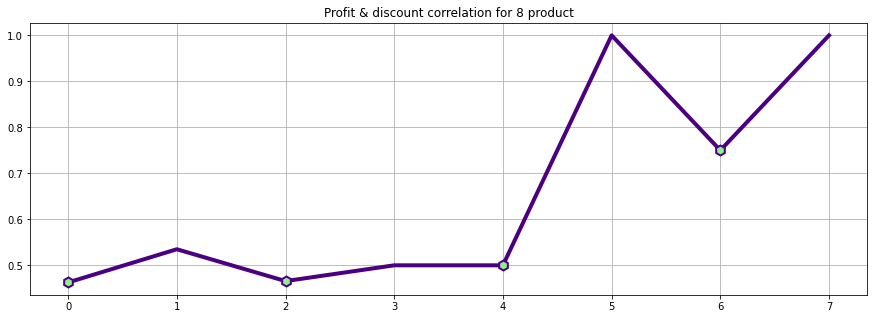

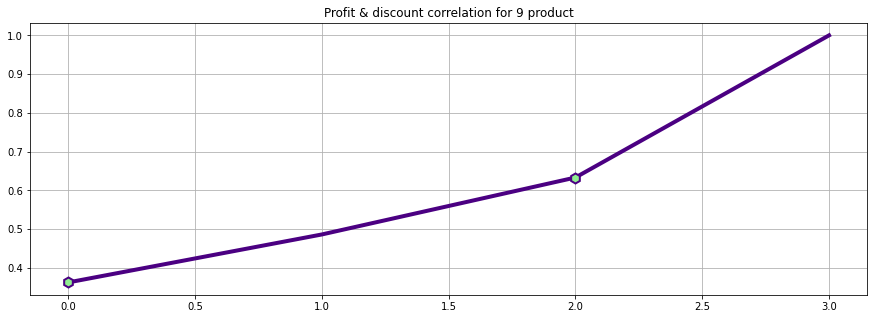

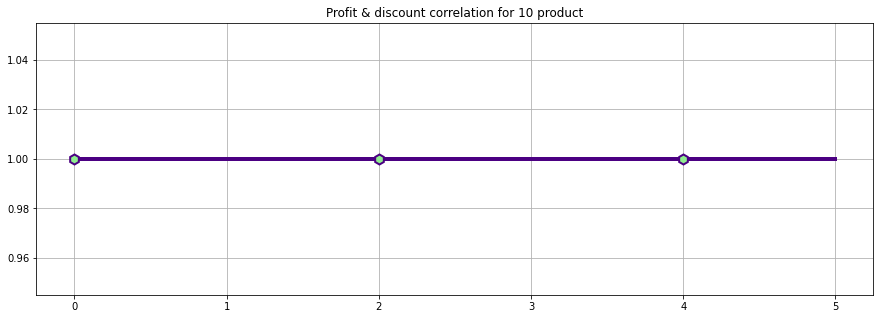

In [564]:
for i in range(10):
  plt.figure(figsize=(15, 5))
  prof = (promo_history[promo_history['skutertiaryid'] == products[i]]['profit'].values)
  discount = (promo_history[promo_history['skutertiaryid'] == products[i]]['chaindiscountvalue'].values)
  plt.title(f'Profit & discount correlation for {i+1} product')
  plt.grid()
  plt.plot(prof/prof.max(), linewidth=3, color='lightcoral', marker='D', markeredgecolor='black')
  plt.plot(discount/discount.max(), color='#4b0082', linewidth=4,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2,
         markersize=10, markevery=2)
  # plt.savefig(f'Profit & discount correlation for {i+1} product.png')
  

Можно заметить что некоторые товары не принесли прибыли вообще. Также видно что значимые акции (те, в период проведения которых совершались покупки)
 проводились только в 2019 году, а в 2020 не было проведено ни одной промо-акции

##Проведем анализ 2019 и 2020 годов.

In [133]:
def get_monthly_profit(year, data):
  df = data[(data['sale_dt'] < datetime.datetime.fromisoformat(f'{str(int(year)+1)}-01-01'))\
                                    & (data['sale_dt'] > datetime.datetime.fromisoformat(f'{str(int(year)-1)}-12-30'))]
  monthly_profit= []
  for month in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
    temp_data = df[(df['sale_dt'] <= datetime.datetime.fromisoformat(f'{year}-{month}-{days_in_months[month]}'))\
                      & (df['sale_dt'] >= datetime.datetime.fromisoformat(f'{year}-{month}-01'))]
    monthly_profit.append(temp_data['salerevenuerub'].sum()/30)
  
  return np.array(monthly_profit)

##Посмотрим на изменение прибыли в течение года

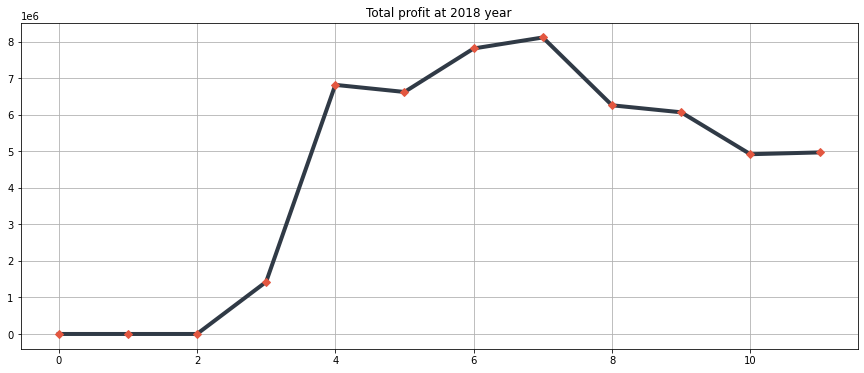

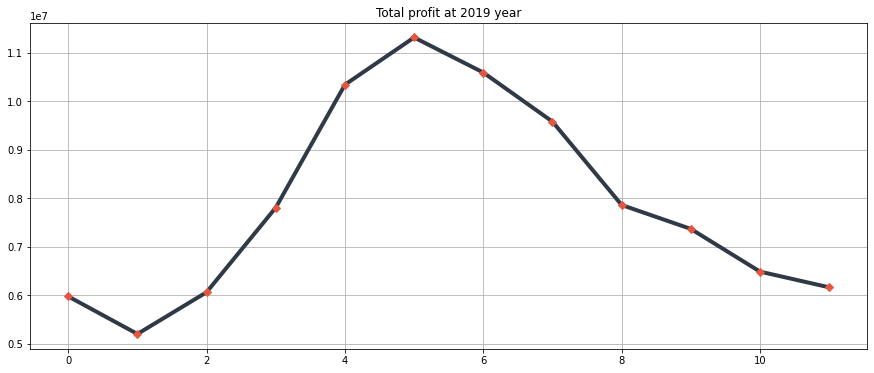

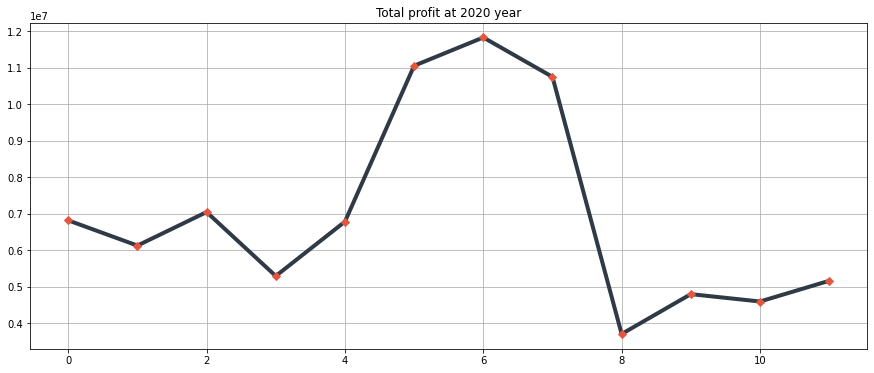

In [250]:
for year in range(2018, 2021):
  plt.figure(figsize=(15, 6))
  plt.title(f'Total profit at {year} year')
  plt.grid()
  plt.plot(get_monthly_profit(str(year), sales_history), color=('#303a46') ,marker='D', markeredgecolor='#e35740', markerfacecolor='#e35740', linewidth=4)
  # plt.savefig(f'Total profit at {year} year.png')


Заметно, как график растет и достигает своего максимума к середине года 

###Для того чтобы вычислить полезные и бесполезные (те, которые не принесли прибыли) акции, совместим данные 2019 и 2020 годов 

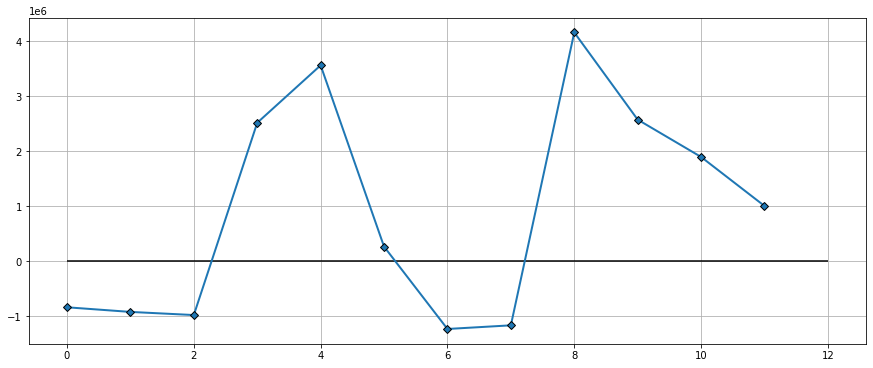

In [565]:
plt.figure(figsize=(15, 6))
y = get_monthly_profit('2019', sales_history)-get_monthly_profit('2020', sales_history)
plt.hlines(0, 0, len(y))
plt.grid()
plt.plot(y, marker='D', markeredgecolor='black', linewidth=2)
# plt.savefig(f'Discount importance.png')

None

Отчетливо видно, все что ниже черной линии (ноль) - акции, которые приносили убытки, все что выше линии - прибыльные акции. Заметно, что самые прибыльные акции приходятся на начало и конец роста спроса продукции.

####Повторим операцию для каждого продукта

In [242]:
def get_promo_importance(product, data):
  plt.figure(figsize=(15, 5))
  data = data[data['skutertiaryid'] == products[product]]
  y = get_monthly_profit('2019', data)-get_monthly_profit('2020', data)
  plt.hlines(0, 0, len(y))
  plt.title(f'Promo importance for {product+1} product')
  plt.grid()
  plt.plot(y, marker='D', markeredgecolor='black', linewidth=2)

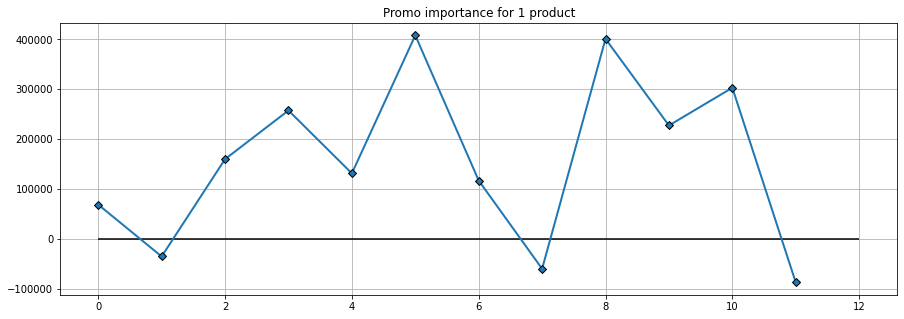

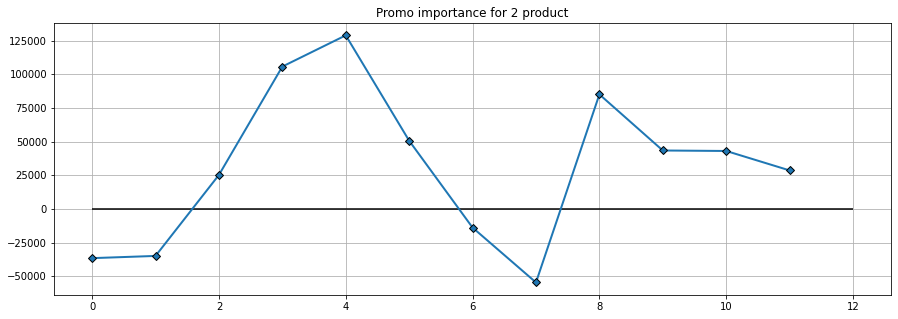

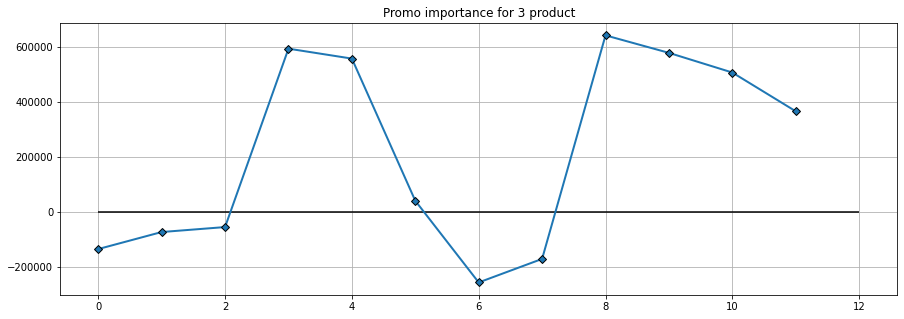

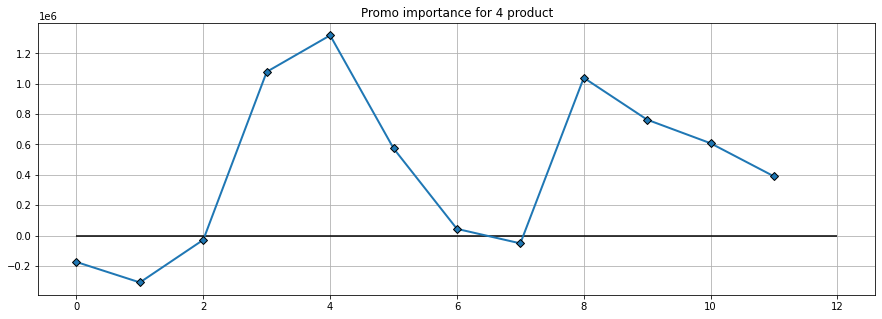

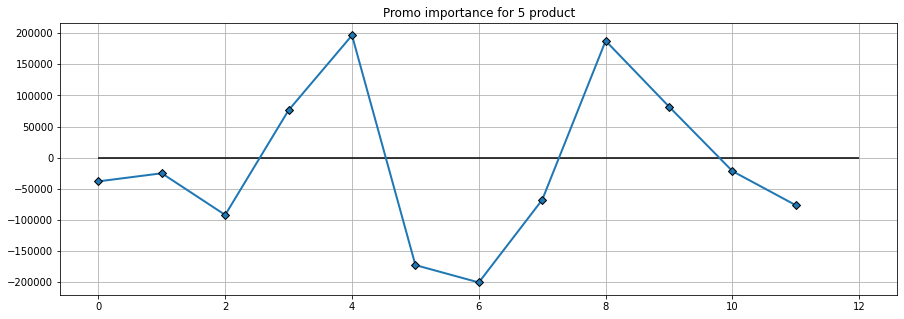

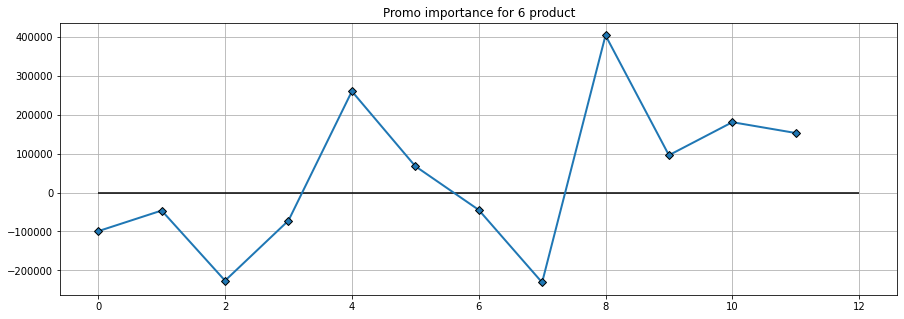

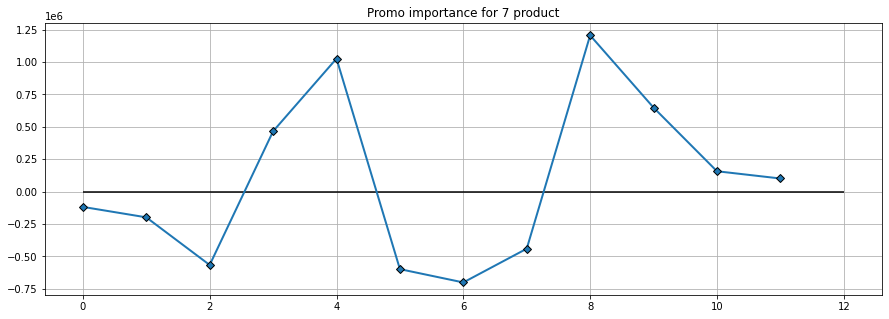

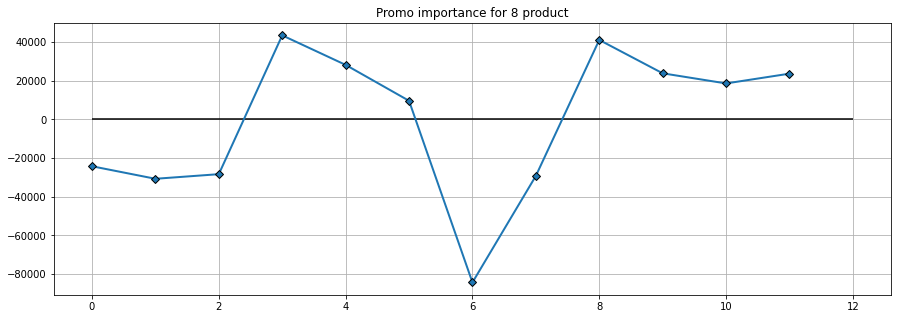

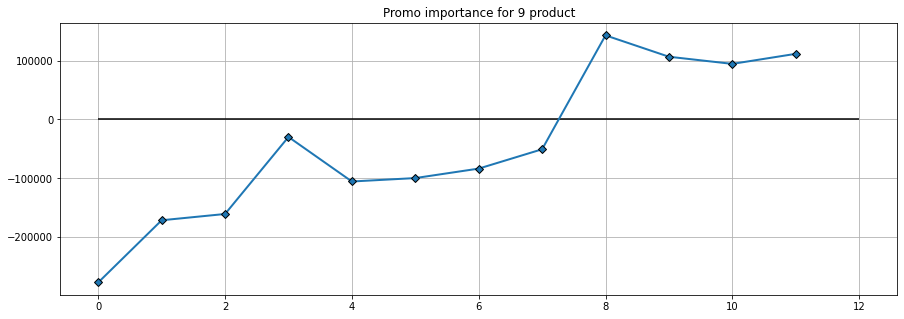

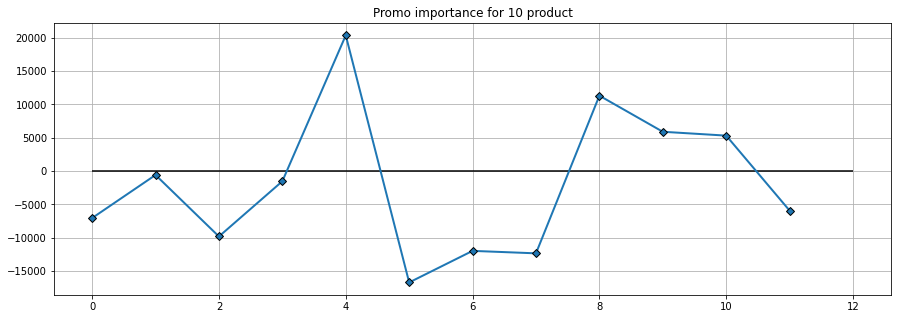

In [566]:
for i in range(10):
  get_promo_importance(i, sales_history)
  # plt.savefig(f'Discount importance{i}.png')


##Обучим модель градиентного бустинга восстанавливать эту зависимость

In [444]:
X_train = []
y_train = []

In [ ]:
for product in products:
  data = sales_history[sales_history['skutertiaryid'] == product]
  y = get_monthly_profit('2019', data)-get_monthly_profit('2020', data)
  for i, profit in enumerate(y):
    for j in range(30):
      X_train.append([i+1,j,str(product)])
      y_train.append(profit)

In [443]:
!pip install CatBoost -q

In [ ]:
from catboost import CatBoostRegressor
cat_features = [2]
model = CatBoostRegressor(iterations=3000)
model.fit(X_train, y_train, cat_features)

In [573]:
model.save_model("model",
           format="cbm",
           export_parameters=None,
           pool=None)

In [574]:
model.load_model('model', format='cbm')

In [520]:
print('Идентификаторы товаров: ',*products.tolist())

Идентификаторы товаров:  7182 7189 7193 7194 7205 7232 7234 7236 7238 7247


###Проверим работоспособность модели

In [ ]:
for product in products:
  preds = []
  for month in range(1,13):
    preds.append(model.predict([month, 1, product]))
  plt.figure(figsize=(10,4))
  plt.title(f'Discount profit for {product} product')
  plt.grid()
  plt.plot(preds, linewidth =2.5)

In [534]:
month, day, product = 5, 1, '7182'

In [536]:
f'Предполагаемая прибыль от проведения акции: {model.predict([month, day, product])}'

'Предполагаемая прибыль от проведения акции: 115700.34761597106'

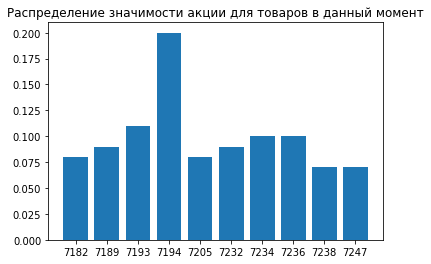

In [562]:
probas = np.array([model.predict([month, day, product]) for product in products])
probas = [round(x,2) for x in softmax(probas/probas.max())]
plt.title('Распределение значимости акции для товаров в данный момент')
plt.bar(range(10), height=probas)
plt.xticks(range(10), products)
None

#Сделаем предсказания и распределение акций по данному бюджету и промежутку времени

In [3]:
N = 100000
start = (2021,1,1)
end = (2021,6,1)

In [8]:
def forecast(money, start, end):
  profits = []
  year1, month1, day1 = start
  year2, month2, day2 = end
  for month in range(1,month2-month1+1+1):
    month = str(month) if month > 9 else '0'+str(month)
    for day in range(1,int(days_in_months[month])+1):
      preds = max([model.predict([int(month), day, product]) for product in products])
      profits.append(preds)
  for day in range(1,day2-day1+1+1):
    preds = max([model.predict([int(month), day, product]) for product in products])
    profits.append(preds) 
  profits = np.array(profits)
  profits /= profits.max()   
  profits = softmax(profits) 
  return profits/profits.max()

In [10]:
days_in_months = [31,30,31,30,31,30,31,30,31,30,31]
probabilities = forecast(N, start, end)

NameError: name 'products' is not defined